### Importing necessary libraries

In [1]:
# scraping twitter
import snscrape.modules.twitter as sntwitter

import re 
import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# NLTK
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords

# sci-kit learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
#from sklearn.feature_extraction.text import TfidVectorizer
from sklearn.metrics import confusion_matrix, classification_report

import json

### Scraping Tweets from a profile

In [2]:
user_tweets = [] # create a list and append the data into it

# scraping 1000 tweets from a user (if available)
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('from:astrotraffic').get_items()):
    if i>10000:
        break
    user_tweets.append([tweet.date, tweet.id, tweet.content, tweet.lang, tweet.user.username])

tweets_df = pd.DataFrame(user_tweets, columns=['Datetime', 'Tweet Id', 'Text', 'Language', 'Username'])


In [3]:
# creating an excel
tweets_df['Datetime'] = tweets_df['Datetime'].dt.tz_localize(None)

tweets_df.to_excel('astro_tweets.xlsx',sheet_name='tweets',index=False) 

### Explaratory Data Analysis (EDA)

In [4]:
len(tweets_df.index) # to check the number of rows

10001

In [5]:
tweets_df.head()

,Datetime,Tweet Id,Text,Language,Username
0,2022-09-11 07:29:57,1568864408914505728,#kltu JALAN SG BESI: Heavy traffic from Jalan ...,en,astrotraffic
1,2022-09-11 07:26:26,1568863522154762241,#kltu KL KARAK HWAY: 40 min jam from Bentong t...,en,astrotraffic
2,2022-09-11 07:19:54,1568861878360875008,PLUS HWAY: 1 hour jam from Ipoh - Gopeng.\n\nA...,en,astrotraffic
3,2022-09-11 07:14:28,1568860510095052803,PLUS HWAY: Slow traffic for 36KM from Simpang ...,en,astrotraffic
4,2022-09-11 07:08:50,1568859094785859584,#jbtu PLUS HWAY: 1 hour 40 min jam from Simpan...,en,astrotraffic


In [6]:
tweets_df.dtypes

Datetime    datetime64[ns]
Tweet Id             int64
Text                object
Language            object
Username            object
dtype: object

In [7]:
tweets_df.columns

Index(['Datetime', 'Tweet Id', 'Text', 'Language', 'Username'], dtype='object')

In [8]:
np.sum(tweets_df.isnull().any(axis=1))

0

In [9]:
tweets_df.dtypes

Datetime    datetime64[ns]
Tweet Id             int64
Text                object
Language            object
Username            object
dtype: object

### Data Cleaning
Removing non-English tweets, punctuatians, special characters and any possible empty rows.

In [10]:
tweets_df["Language"].unique()

array(['en', 'in', 'tl', 'ca', 'zxx', 'fr', 'und', 'et', 'no', 'ro', 'pt',
       'qht', 'fi', 'qam', 'de', 'cy', 'hi', 'da'], dtype=object)

In [11]:
tweets_df = tweets_df[tweets_df["Language"].isin([ 'und', 'en'])]

In [12]:
len(tweets_df.index) # to check the number of rows

5485

In [13]:
tweets_df.head()

,Datetime,Tweet Id,Text,Language,Username
0,2022-09-11 07:29:57,1568864408914505728,#kltu JALAN SG BESI: Heavy traffic from Jalan ...,en,astrotraffic
1,2022-09-11 07:26:26,1568863522154762241,#kltu KL KARAK HWAY: 40 min jam from Bentong t...,en,astrotraffic
2,2022-09-11 07:19:54,1568861878360875008,PLUS HWAY: 1 hour jam from Ipoh - Gopeng.\n\nA...,en,astrotraffic
3,2022-09-11 07:14:28,1568860510095052803,PLUS HWAY: Slow traffic for 36KM from Simpang ...,en,astrotraffic
4,2022-09-11 07:08:50,1568859094785859584,#jbtu PLUS HWAY: 1 hour 40 min jam from Simpan...,en,astrotraffic


In [14]:
tweets_df.reset_index(inplace=True)
tweets_df.drop("index",axis =1,inplace=True)

In [15]:
def data_clean(text):  
    re1 = r'@[^ ]+'                   #@signs
    re2 = r'https?://[A-Za-z0-9./]+'  #links
    re3 = r'\'s'                      #floating s's
    re4 = r'\#\w+'                    #hashtags
    re5 = r'&amp '
    re6 = r'[^A-Za-z\s]'              #non-alphabet
    combined_re = r'|'.join((re1, re2, re3, re4, re5, re6))
    text = re.sub(combined_re,"",text).lower()
    return text.strip()

In [16]:
tweets_df["cleaned_tweets"] = tweets_df["Text"].apply(data_clean)

In [17]:
tweets_df = tweets_df [ ~(tweets_df["Text"] =="")]

In [18]:
tweets_df["cleaned_tweets"].head()

0    jalan sg besi heavy traffic from jalan istana ...
1    kl karak hway  min jam from bentong toll  lent...
2    plus hway  hour jam from ipoh  gopeng\n\nalso ...
3    plus hway slow traffic for km from simpang amp...
4    plus hway  hour  min jam from simpang renggam ...
Name: cleaned_tweets, dtype: object

In [19]:
tweets_df.head()

,Datetime,Tweet Id,Text,Language,Username,cleaned_tweets
0,2022-09-11 07:29:57,1568864408914505728,#kltu JALAN SG BESI: Heavy traffic from Jalan ...,en,astrotraffic,jalan sg besi heavy traffic from jalan istana ...
1,2022-09-11 07:26:26,1568863522154762241,#kltu KL KARAK HWAY: 40 min jam from Bentong t...,en,astrotraffic,kl karak hway min jam from bentong toll lent...
2,2022-09-11 07:19:54,1568861878360875008,PLUS HWAY: 1 hour jam from Ipoh - Gopeng.\n\nA...,en,astrotraffic,plus hway hour jam from ipoh gopeng\n\nalso ...
3,2022-09-11 07:14:28,1568860510095052803,PLUS HWAY: Slow traffic for 36KM from Simpang ...,en,astrotraffic,plus hway slow traffic for km from simpang amp...
4,2022-09-11 07:08:50,1568859094785859584,#jbtu PLUS HWAY: 1 hour 40 min jam from Simpan...,en,astrotraffic,plus hway hour min jam from simpang renggam ...


### TextBlob
Providing each tweet with a polarity

In [20]:
#print("Running sentiment process")
for row in tweets_df.itertuples():
    tweet = tweets_df.at[row[0], 'cleaned_tweets']

    #run sentiment using TextBlob
    analysis = TextBlob(tweet)

    #set value to dataframe
    tweets_df.at[row[0], 'polarity'] = analysis.sentiment[0]
    tweets_df.at[row[0], 'subjectivity'] = analysis.sentiment[1]

    #Create Positive / negative column depending on polarity
    if analysis.sentiment[0]>0:
        tweets_df.at[row[0], 'Sentiment'] = "Positive"
    elif analysis.sentiment[0]<0:
        tweets_df.at[row[0], 'Sentiment'] = "Negative"
    else:
        tweets_df.at[row[0], 'Sentiment'] = "Neutral"

In [21]:
tweets_df[["cleaned_tweets","polarity","Sentiment"]].head(5)

,cleaned_tweets,polarity,Sentiment
0,jalan sg besi heavy traffic from jalan istana ...,-0.013095,Negative
1,kl karak hway min jam from bentong toll lent...,-0.166667,Negative
2,plus hway hour jam from ipoh gopeng\n\nalso ...,-0.300000,Negative
3,plus hway slow traffic for km from simpang amp...,-0.300000,Negative
4,plus hway hour min jam from simpang renggam ...,-0.012500,Negative


In [22]:
tweets_df.to_excel('sentiment_analysis.xlsx',sheet_name='tweets',index=False) 

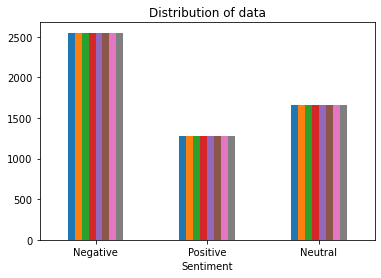

In [23]:
ax = tweets_df.groupby('Sentiment').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive','Neutral'], rotation=0)
# Storing data in lists.
Text, sentiment = list(tweets_df['Text']), list(tweets_df['Sentiment'])

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

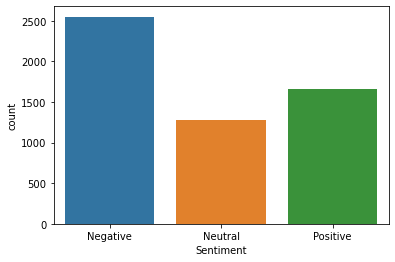

In [24]:
sns.countplot(x='Sentiment', data=tweets_df)

In [26]:
# Tokenization of the tweets
#data = tweets_df['cleaned_tweets']
#tweets_df1 = pd.DataFrame(data)
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer()
tweets_df1['cleaned_tweets'] = tweets_df1['cleaned_tweets'].apply(tweet_tokenizer.tokenize)


In [27]:
tweets_df1.head()

,cleaned_tweets
0,"[jalan, sg, besi, heavy, traffic, from, jalan,..."
1,"[kl, karak, hway, min, jam, from, bentong, tol..."
2,"[plus, hway, hour, jam, from, ipoh, gopeng, al..."
3,"[plus, hway, slow, traffic, for, km, from, sim..."
4,"[plus, hway, hour, min, jam, from, simpang, re..."


In [28]:
# stemming
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
tweets_df1['cleaned_tweets'] = tweets_df1['cleaned_tweets'].apply(lambda x: stemming_on_text(x))

In [29]:
tweets_df1.head()

,cleaned_tweets
0,"[jalan, sg, besi, heavy, traffic, from, jalan,..."
1,"[kl, karak, hway, min, jam, from, bentong, tol..."
2,"[plus, hway, hour, jam, from, ipoh, gopeng, al..."
3,"[plus, hway, slow, traffic, for, km, from, sim..."
4,"[plus, hway, hour, min, jam, from, simpang, re..."


In [30]:
# lemmatizer
#nltk.download('wordnet')
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
tweets_df1['cleaned_tweets'] = tweets_df1['cleaned_tweets'].apply(lambda x: lemmatizer_on_text(x))

In [31]:
tweets_df1['cleaned_tweets'].head()

0    [jalan, sg, besi, heavy, traffic, from, jalan,...
1    [kl, karak, hway, min, jam, from, bentong, tol...
2    [plus, hway, hour, jam, from, ipoh, gopeng, al...
3    [plus, hway, slow, traffic, for, km, from, sim...
4    [plus, hway, hour, min, jam, from, simpang, re...
Name: cleaned_tweets, dtype: object

In [32]:
X = tweets_df.cleaned_tweets
y = tweets_df.Sentiment

In [33]:
tweets_df.loc[tweets_df['Sentiment'] == 'Negative']

,Datetime,Tweet Id,Text,Language,Username,cleaned_tweets,polarity,subjectivity,Sentiment
0,2022-09-11 07:29:57,1568864408914505728,#kltu JALAN SG BESI: Heavy traffic from Jalan ...,en,astrotraffic,jalan sg besi heavy traffic from jalan istana ...,-0.013095,0.470238,Negative
1,2022-09-11 07:26:26,1568863522154762241,#kltu KL KARAK HWAY: 40 min jam from Bentong t...,en,astrotraffic,kl karak hway min jam from bentong toll lent...,-0.166667,0.300000,Negative
2,2022-09-11 07:19:54,1568861878360875008,PLUS HWAY: 1 hour jam from Ipoh - Gopeng.\n\nA...,en,astrotraffic,plus hway hour jam from ipoh gopeng\n\nalso ...,-0.300000,0.400000,Negative
3,2022-09-11 07:14:28,1568860510095052803,PLUS HWAY: Slow traffic for 36KM from Simpang ...,en,astrotraffic,plus hway slow traffic for km from simpang amp...,-0.300000,0.400000,Negative
4,2022-09-11 07:08:50,1568859094785859584,#jbtu PLUS HWAY: 1 hour 40 min jam from Simpan...,en,astrotraffic,plus hway hour min jam from simpang renggam ...,-0.012500,0.387500,Negative
...,...,...,...,...,...,...,...,...,...
5469,2021-09-29 10:30:01,1443161135361011714,Avoid 17 Lebuhraya Pasir Gudang #kltu. You'll ...,en,astrotraffic,avoid lebuhraya pasir gudang youll be stuck ...,-0.250000,0.250000,Negative
5474,2021-09-29 10:28:58,1443160868976533505,UPDATE: 1 Jalan Gopeng - Kampar still jammed. ...,en,astrotraffic,update jalan gopeng kampar still jammed will...,-0.100000,0.600000,Negative
5475,2021-09-29 10:28:55,1443160856385236997,1-11C Jalan Penrissen Kuching is 10m slower th...,en,astrotraffic,c jalan penrissen kuching is m slower than usu...,-0.250000,0.250000,Negative
5477,2021-09-29 10:26:56,1443160358051631107,UPDATE: K669 Jalan Kempas still jammed. Will a...,en,astrotraffic,update k jalan kempas still jammed will add m ...,-0.100000,0.600000,Negative


In [34]:
data_negative = tweets_df.loc[tweets_df['Sentiment'] == 'Negative']
df = pd.DataFrame(data_negative)
df1 = df[df.columns[5]]
neg_df = pd.DataFrame(df1)
neg_df.tail()

,cleaned_tweets
5469,avoid lebuhraya pasir gudang youll be stuck ...
5474,update jalan gopeng kampar still jammed will...
5475,c jalan penrissen kuching is m slower than usu...
5477,update k jalan kempas still jammed will add m ...
5479,avoid lebuhraya pasir gudang youll be stuck ...


In [35]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves', 'due', 'causing']

STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
neg_df['cleaned_tweets'] = neg_df['cleaned_tweets'].apply(lambda text: cleaning_stopwords(text))

neg_df['cleaned_tweets'] = neg_df['cleaned_tweets'].str.replace("'", "")
neg_df['cleaned_tweets'] = neg_df['cleaned_tweets'].str.replace("'", "")
#neg_df.to_csv('tokenized_tweets.csv') 
neg_df['cleaned_tweets'].head()

0    jalan sg besi heavy traffic jalan istana tudm ...
1    kl karak hway min jam bentong toll lentang slo...
2    plus hway hour jam ipoh gopeng also expect slo...
3    plus hway slow traffic km simpang ampat seremb...
4    plus hway hour min jam simpang renggam sedenak...
Name: cleaned_tweets, dtype: object

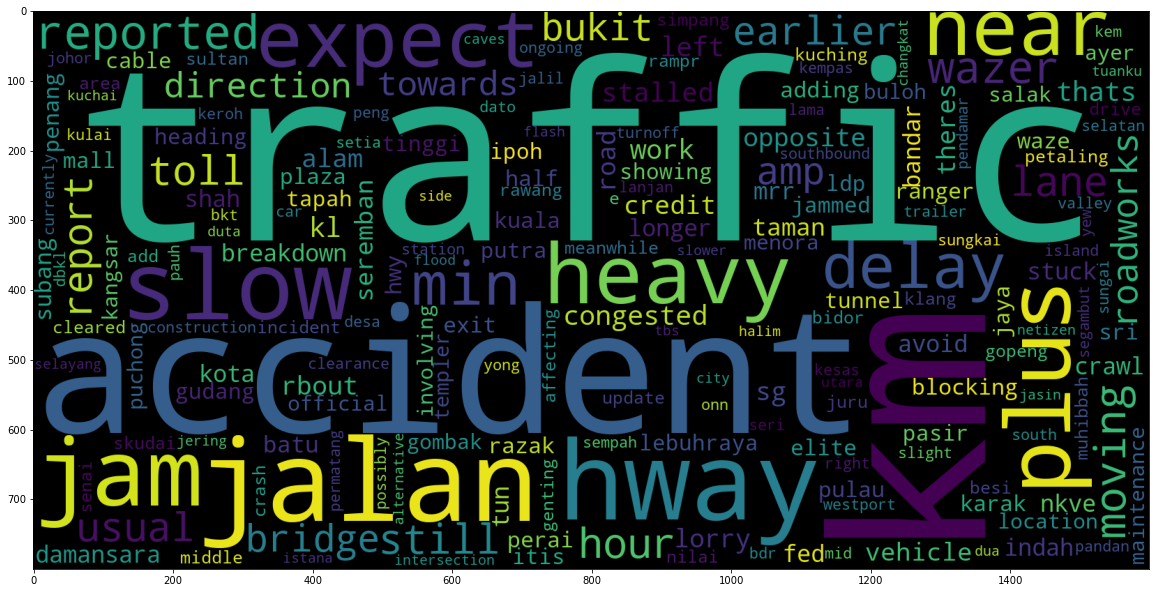

In [36]:
x = neg_df.cleaned_tweets
y = tweets_df.Sentiment

data_neg = neg_df['cleaned_tweets'][:10000]
plt.figure(figsize = (20,20))
wc = WordCloud(width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

In [37]:
data_positive = tweets_df.loc[tweets_df['Sentiment'] == 'Positive']
df = pd.DataFrame(data_positive)
df1 = df[df.columns[5]]
pos_df = pd.DataFrame(df1)
pos_df.tail()

,cleaned_tweets
5476,stay clear of jalan kuching near jalan ipoh ...
5478,stay clear of jalan kuching near jalan ipoh ...
5481,stay clear of jalan kuching near jalan ipoh ...
5482,stay clear of lebuhraya pasir gudang drive t...
5483,stay clear of lebuhraya pasir gudang johor ba...


In [38]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves', 'due', 'causing']

STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
pos_df['cleaned_tweets'] = pos_df['cleaned_tweets'].apply(lambda text: cleaning_stopwords(text))

pos_df['cleaned_tweets'] = pos_df['cleaned_tweets'].str.replace("'", "")
pos_df['cleaned_tweets'] = pos_df['cleaned_tweets'].str.replace("'", "")
#neg_df.to_csv('tokenized_tweets.csv') 
pos_df['cleaned_tweets'].head()

8     congested hour ldp penchala toll puchong jaya ...
9     nkve car breakdown reported km blocking right ...
13    plus hway lorry fire km currently blocking rig...
15    jalan sg buloh stalled vehicle reported near s...
18    jalan rawang accident near templers park repor...
Name: cleaned_tweets, dtype: object

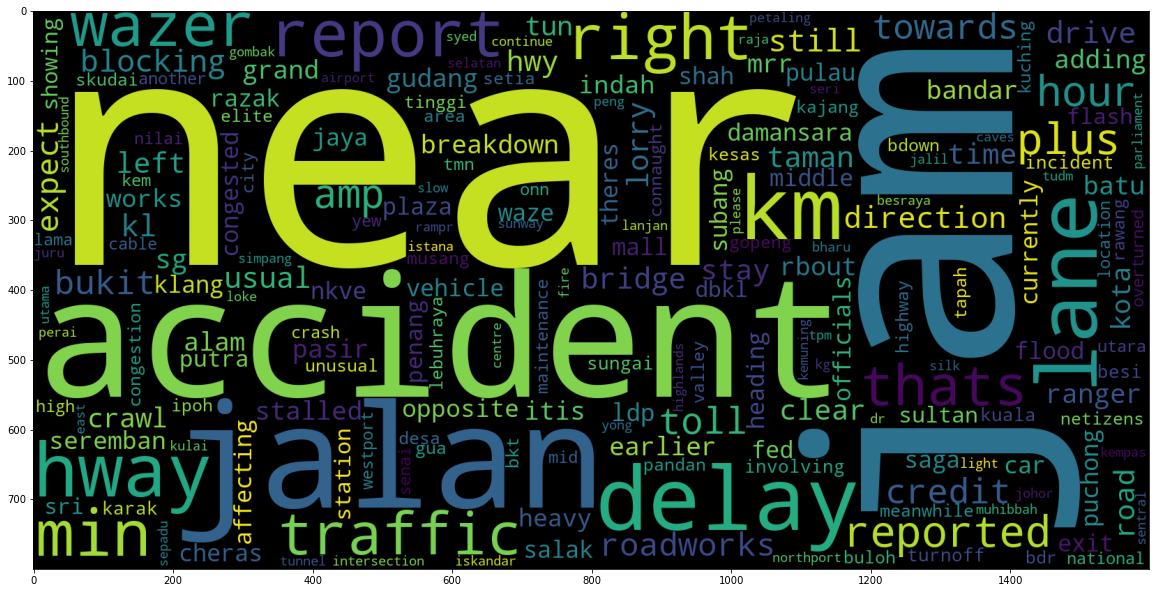

In [39]:
x = pos_df.cleaned_tweets
y = tweets_df.Sentiment

data_pos = pos_df['cleaned_tweets'][:10000]
plt.figure(figsize = (20,20))
wc = WordCloud(width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_pos))
plt.imshow(wc)

### Linear Regression

In [41]:
#options = ['Positive','Negative']
#data_neg_pos = tweets_df.loc[tweets_df['Sentiment'].isin(options)]
#lr_dataset = pd.DataFrame(data_neg_pos)
#lr_dataset.head()
X = lr_dataset.cleaned_tweets
y = lr_dataset.Sentiment

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=50000)
vectoriser.fit(X_train)

print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  14328


C:\Users\Clifford\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [44]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [45]:
def model_Evaluate(model):
# Predict values for Test dataset
    y_pred = model.predict(X_test)
# Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
# Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = True, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

    Negative       0.98      0.97      0.97       134
    Positive       0.95      0.96      0.95        77

    accuracy                           0.97       211
   macro avg       0.96      0.97      0.96       211
weighted avg       0.97      0.97      0.97       211



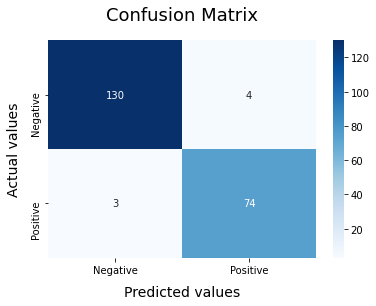

In [46]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

### Reference

Analytics Vidhya. 2021. Twitter Sentiment Analysis - A NLB Use-Case for Beginners. [online] Available at: https://www.analyticsvidhya.com/blog/2021/06/twitter-sentiment-analysis-a-nlp-use-case-for-beginners/ [Accessed 11 September 2022].

GitHub. 2021. Sentiment Analysis of South African Banks PCO. [online] Available at: https://github.com/Slyth3/Sentiment-analysis-of-South-African-Banks-POC/blob/main/Twint_SentimentAnalysis.ipynb [Accessed 11 September 2022].
